<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/flower_photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Rescaling,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom
from tensorflow.keras.models import Sequential

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

flower_photo/
  * daisy/
  * dandelion/
  * roses/
  * sunflowers/
  * tulips/








In [2]:
# download data
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

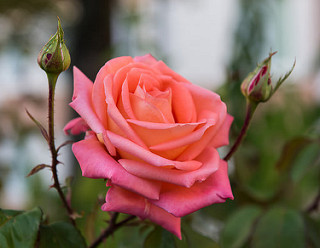

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[3]))

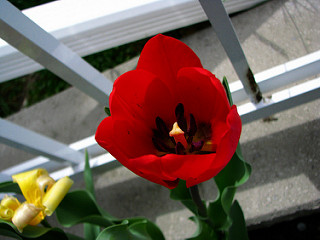

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [6]:
# Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory 
# utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a
# couple lines of code.

# define dome the parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

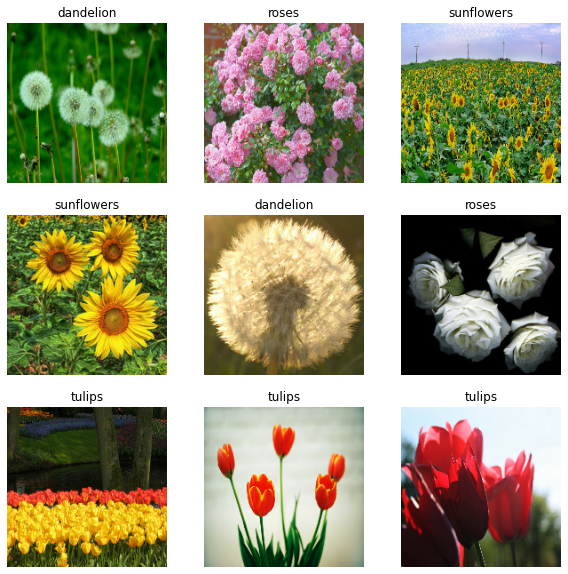

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
# Make sure to use buffered prefetching, so you can yield data from disk without having 
# I/O become blocking. These are two important methods you should use when loading data:
# 1. Dataset.cache  2. Dataset.prefetch 

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = len(class_names)

def create_model():
  model = Sequential()
  
  # add data augmentation layers
  model.add(RandomFlip('horizontal',input_shape=(img_height,img_width,3)))
  model.add(RandomRotation(0.1))
  model.add(RandomZoom(0.1))

  # Normalize/standardize RGB channel values [0, 255] to a range in the [0, 1]
  model.add(Rescaling(1./255))

  # three convolution blocks with a max pooling layer in each of them
  model.add(Conv2D(16,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(64,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())

  # Add a layer of dropout layer
  model.add(Dropout(0.5))

  # flatten image for Dense layer
  model.add(Flatten())

  # fully-connected layer with 128 units on top of it that is activated by a ReLU 
  # activation function   
  model.add(Dense(128,activation='relu'))
  
  model.add(Dropout(0.5))
  model.add(Dense(128,activation='relu'))

  model.add(Dense(num_classes))


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model



In [18]:
def evaluate(model,epochs):
  model.summary()
  history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


  


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      208       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                 

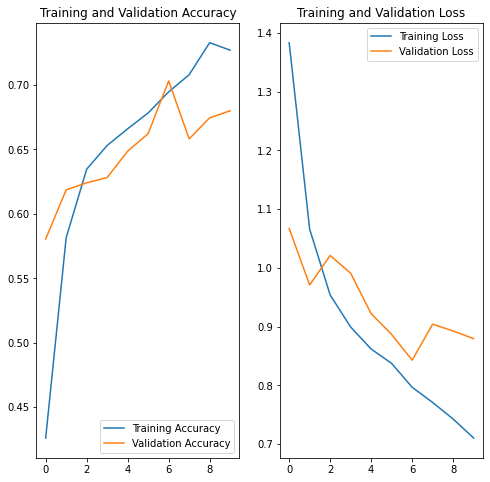

In [ ]:
model = create_model()
evaluate(model,10)

In [ ]:
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

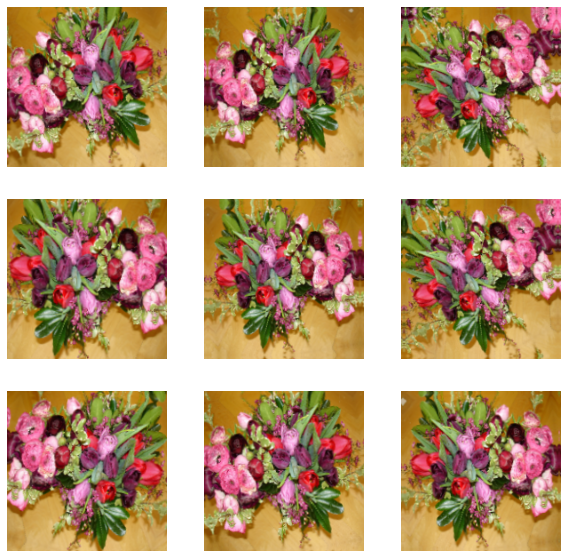

In [ ]:
# Visualize a few augmented examples by applying data augmentation to the same 
# image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                      

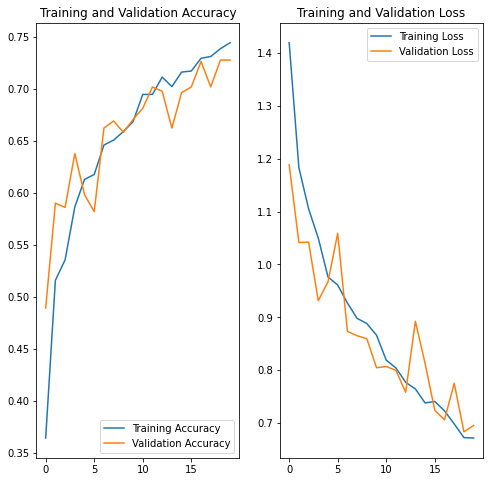

In [19]:
model2 = create_model()
evaluate(model2,20)

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 202ms/step
This image most likely belongs to sunflowers with a 87.38 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model2 = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model2)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['random_flip_9_input'],
  'outputs': ['dense_27']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(random_flip_9_input)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

NameError: ignored